In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid
import pickle
import os

file_path = "GOOG.csv"  
data = pd.read_csv(file_path)

data.describe()

,Low,Open,Volume,High,Close,Adjusted Close
count,4612.000000,4612.000000,4.612000e+03,4612.000000,4612.000000,4612.000000
mean,37.088474,37.471847,1.238896e+08,37.856624,37.477273,37.477273
std,34.791176,35.163155,1.536223e+08,35.549294,35.170034,35.170034
min,2.390042,2.470490,1.584340e+05,2.534002,2.490913,2.490913
25%,12.401765,12.575302,2.992850e+07,12.697718,12.576174,12.576174
50%,22.808758,22.980115,6.869051e+07,23.098795,22.954461,22.954461
75%,52.975875,53.578501,1.549155e+08,54.106961,53.534375,53.534375
max,149.887497,151.863495,1.650833e+09,152.100006,150.709000,150.709000


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4612 entries, 0 to 4611
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4612 non-null   object 
 1   Low             4612 non-null   float64
 2   Open            4612 non-null   float64
 3   Volume          4612 non-null   int64  
 4   High            4612 non-null   float64
 5   Close           4612 non-null   float64
 6   Adjusted Close  4612 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 252.3+ KB


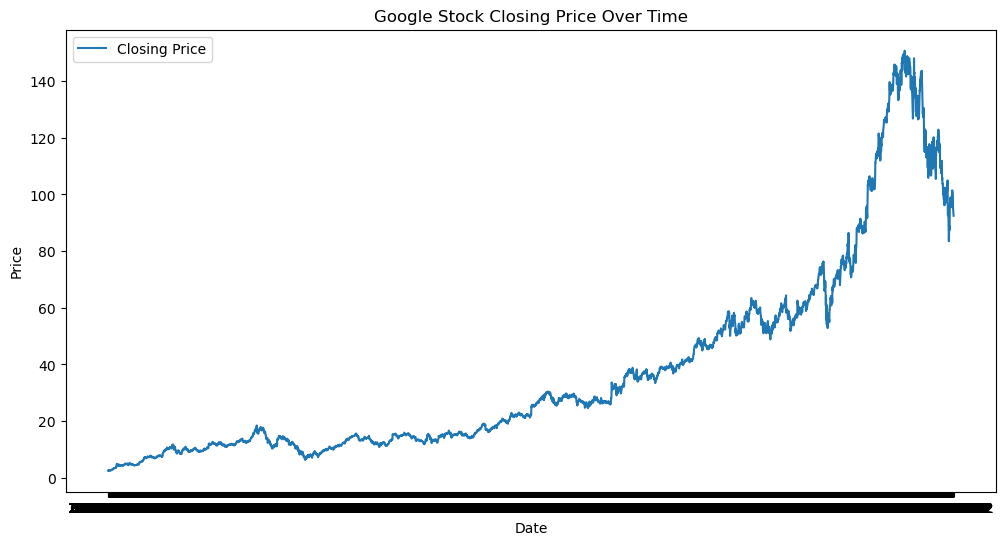

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Closing Price')
plt.title('Google Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [21]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

/var/folders/5t/y59tw_y15s52ws40_hv9jl3m0000gn/T/ipykernel_5268/889507750.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


In [41]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Volume', 'Close']])

scaled_df = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Volume', 'Close'], index=data.index)
print(scaled_df)


                Open      High       Low    Volume     Close
Date                                                        
2004-08-19  0.000135  0.000386  0.000000  0.543577  0.000055
2004-08-20  0.000303  0.001222  0.000767  0.277886  0.001395
2004-08-23  0.001927  0.001955  0.002210  0.222151  0.001578
2004-08-24  0.002009  0.001642  0.001285  0.185523  0.000817
2004-08-25  0.000962  0.001042  0.001337  0.111765  0.001007
...              ...       ...       ...       ...       ...
2022-06-12  0.650630  0.653063  0.639807  0.012552  0.639727
2022-07-12  0.631218  0.633673  0.628044  0.016048  0.625154
2022-08-12  0.623988  0.624046  0.619739  0.015409  0.617058
2022-09-12  0.612007  0.614819  0.614451  0.013155  0.611120
2022-12-12  0.606585  0.610704  0.606858  0.004524  0.607106

[4612 rows x 5 columns]


In [23]:
train_ratio = 0.7
val_ratio = 0.2

train_size = int(len(scaled_df) * train_ratio)
val_size = int(len(scaled_df) * (train_ratio + val_ratio))

train_data = scaled_df.iloc[:train_size]
val_data = scaled_df.iloc[train_size:val_size]
test_data = scaled_df.iloc[val_size:]

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")

Train size: 3228, Validation size: 922, Test size: 462


In [24]:
def create_dataset(data, time_steps, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - time_steps - forecast_horizon):
        X.append(data.iloc[i:i + time_steps, :].values)
        y.append(data.iloc[i + time_steps:i + time_steps + forecast_horizon, -1].values)
    return np.array(X), np.array(y)

time_steps = 30  # N = 30
forecast_horizon = 1  # M = 1
X_train, y_train = create_dataset(train_data, time_steps, forecast_horizon)
X_val, y_val = create_dataset(val_data, time_steps, forecast_horizon)
X_test, y_test = create_dataset(test_data, time_steps, forecast_horizon)

In [25]:
def inverse_transform_data(scaler, y_data, y_pred):
    y_data = np.reshape(y_data, (-1, 1))  
    y_pred = np.reshape(y_pred, (-1, 1)) 
    
    y_data_rescaled = scaler.inverse_transform(np.hstack([np.zeros((y_data.shape[0], 4)), y_data]))[:, -1]
    y_pred_rescaled = scaler.inverse_transform(np.hstack([np.zeros((y_pred.shape[0], 4)), y_pred]))[:, -1]
    
    return y_data_rescaled, y_pred_rescaled

In [26]:
def evaluate_model(history, y_test, y_pred, scaler, params=None):
    y_test_rescaled, y_pred_rescaled = inverse_transform_data(scaler, y_test, y_pred)
    
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Validation Loss')
    plt.plot(history.history['val_loss'], label='Train Loss')
    
    title = 'Model Loss'
    if params:
        title = f"{title} - Units: {params['units']}, Dropout: {params['dropout']}, Batch Size: {params['batch_size']}"
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    plt.plot(y_test_rescaled, label='Actual Values', linestyle='-', color='black', alpha=0.5)
    plt.plot(y_pred_rescaled, label='Predicted Values', linestyle='--', color='blue')
    plt.title('Predictions vs Actual Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


In [27]:
def train_and_save_model(model, model_name, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, params=None):
    model_filename = f"save/{model_name}.keras"
    history_filename = f"save/{model_name}_history.pkl" 

    if os.path.exists(model_filename):
        print(f"Loading pre-trained model: {model_name}")
        model = load_model(model_filename)

        if os.path.exists(history_filename):
            with open(history_filename, 'rb') as f:
                history = pickle.load(f)
            print(f"Loaded history for model {model_name}")
        else:
            print(f"History not found for {model_name}, no plot available.")
            history = None
    else:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', save_best_only=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                            validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint, lr_scheduler])

        with open(history_filename, 'wb') as f:
            pickle.dump(history, f)

    if history:
        evaluate_model(history, y_val, model.predict(X_val), scaler, params)
    
    return model

Epoch 1/50


/Users/chung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1093 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0122 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0073 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0065 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 7/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - val_loss: 0.0332 - learning_rate: 0.0010
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0329 - learning_rate: 2.0000e-04
Epoch 9/50


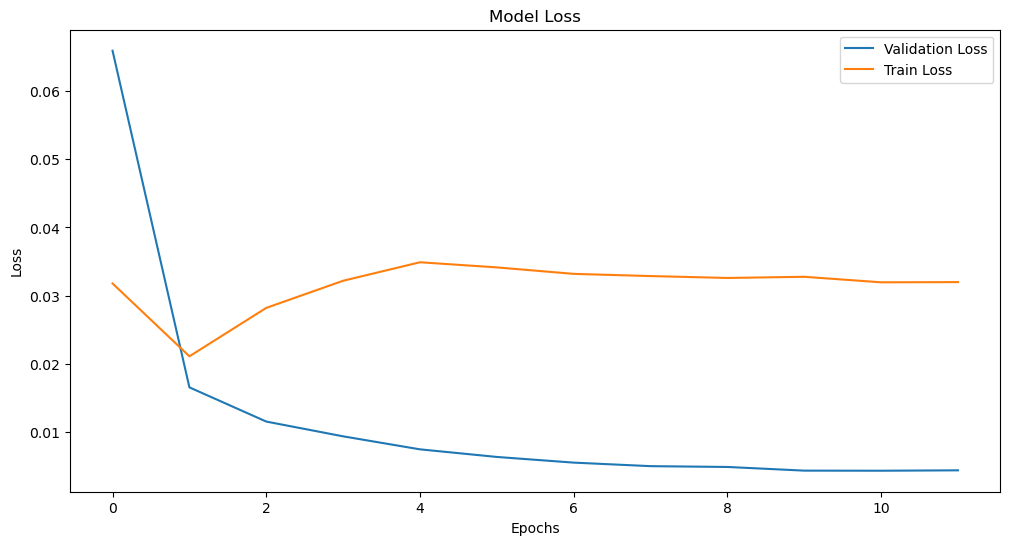

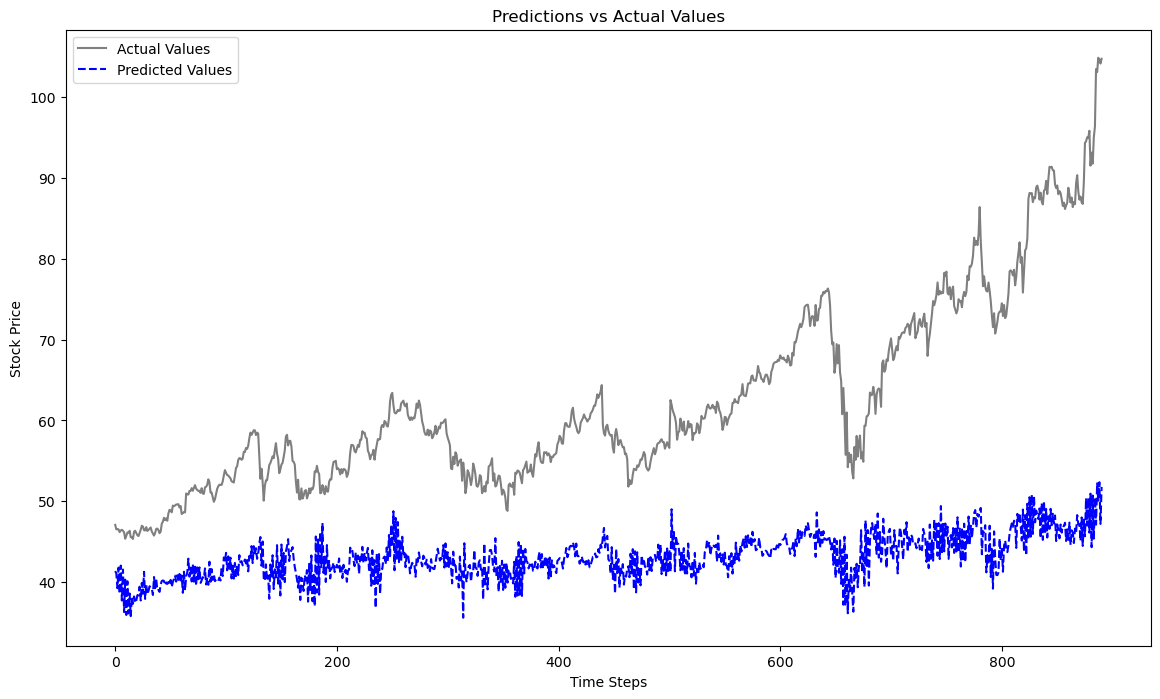

<Sequential name=sequential_13, built=True>

In [28]:
def build_baseline_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=5, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(units=1)) 
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

baseline_rnn = build_baseline_rnn_model((X_train.shape[1], X_train.shape[2]))
train_and_save_model(baseline_rnn, 'baseline_rnn', X_train, y_train, X_val, y_val, epochs=50, batch_size=64)

Training with params: {'batch_size': 64, 'dropout': 0.3, 'epochs': 50, 'units': 10}
Epoch 1/50


/Users/chung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0610 - val_loss: 0.1598 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0234 - val_loss: 0.1528 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0194 - val_loss: 0.1372 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0152 - val_loss: 0.1270 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0132 - val_loss: 0.1150 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - val_loss: 0.0949 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0112 - val_loss: 0.0874 - learning_rate: 0.0010
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0095 - val_loss: 0.0775 - learning_rate: 0.0010
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━

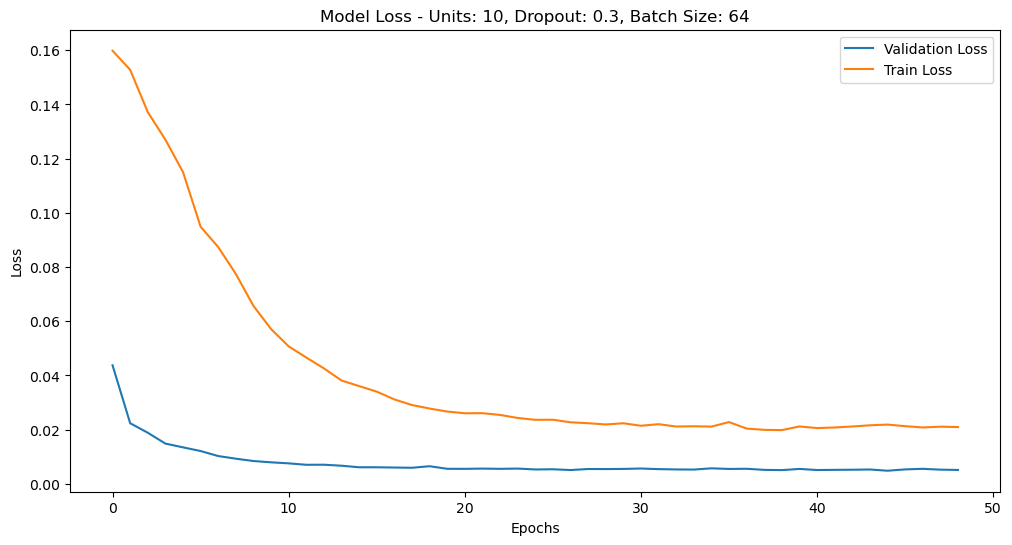

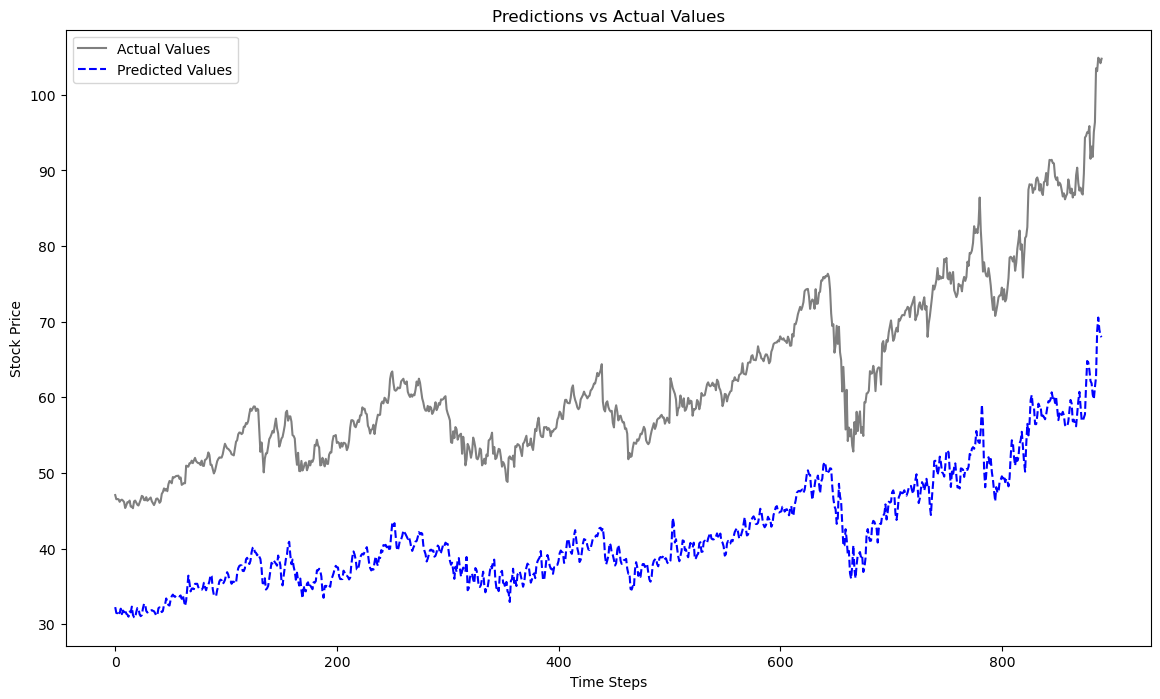

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with params: {'batch_size': 64, 'dropout': 0.3, 'epochs': 50, 'units': 30}
Epoch 1/50


/Users/chung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0770 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0501 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0319 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0254 - val_loss: 0.0458 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0185 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 6/50
45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0167 - val_loss: 0.0511 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0156 - val_loss: 0.0532 - learning_rate: 2.0000e-04
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0134 - val_loss: 0.0539 - learning_rate: 2.0000e-04
Epoch 9

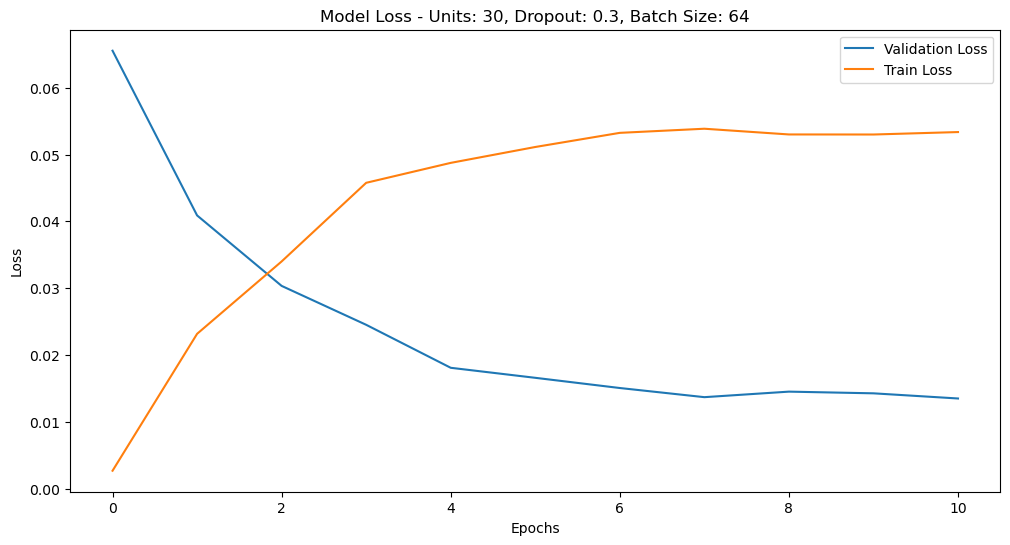

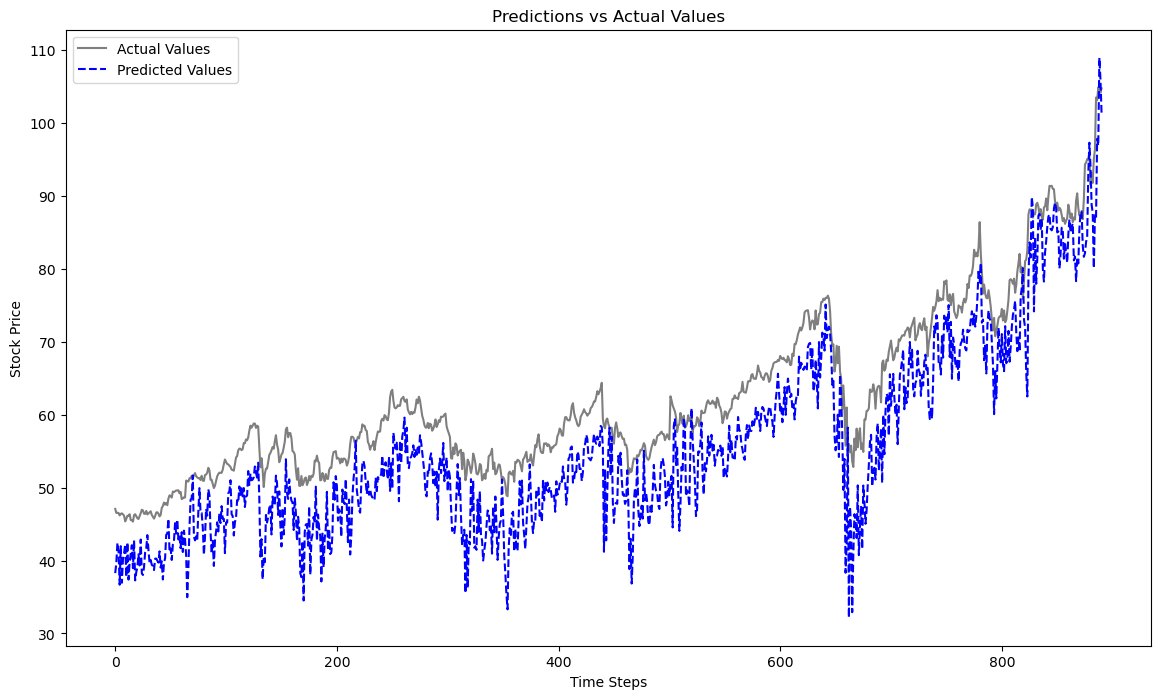

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with params: {'batch_size': 64, 'dropout': 0.5, 'epochs': 50, 'units': 10}
Epoch 1/50


/Users/chung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1235 - val_loss: 0.2529 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0278 - val_loss: 0.1858 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0217 - val_loss: 0.1475 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0198 - val_loss: 0.1253 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0176 - val_loss: 0.1078 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0168 - val_loss: 0.0976 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0157 - val_loss: 0.0946 - learning_rate: 0.0010
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153 - val_loss: 0.0855 - learning_rate: 0.0010
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0141 - val_loss: 0.0790 - learning_rate: 0.0010
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━

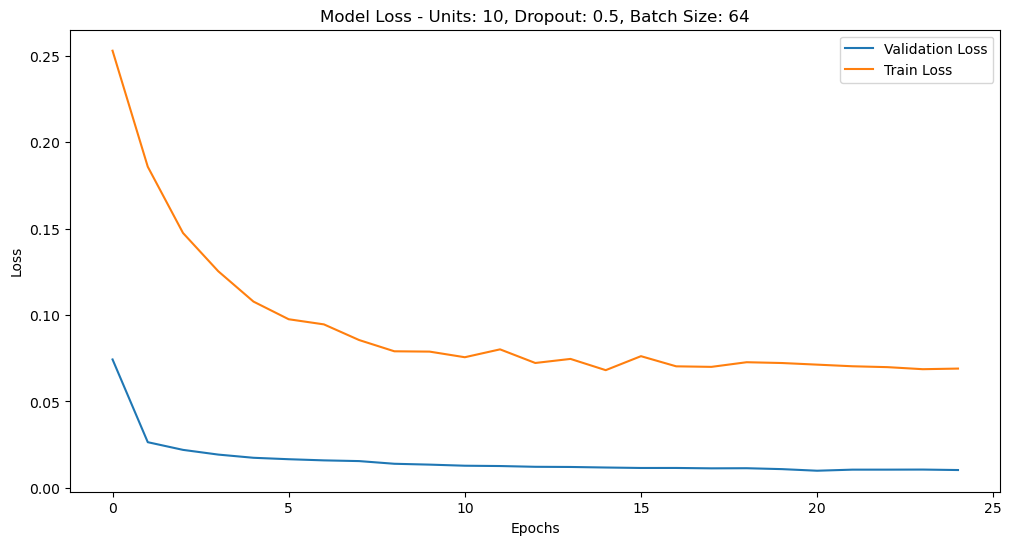

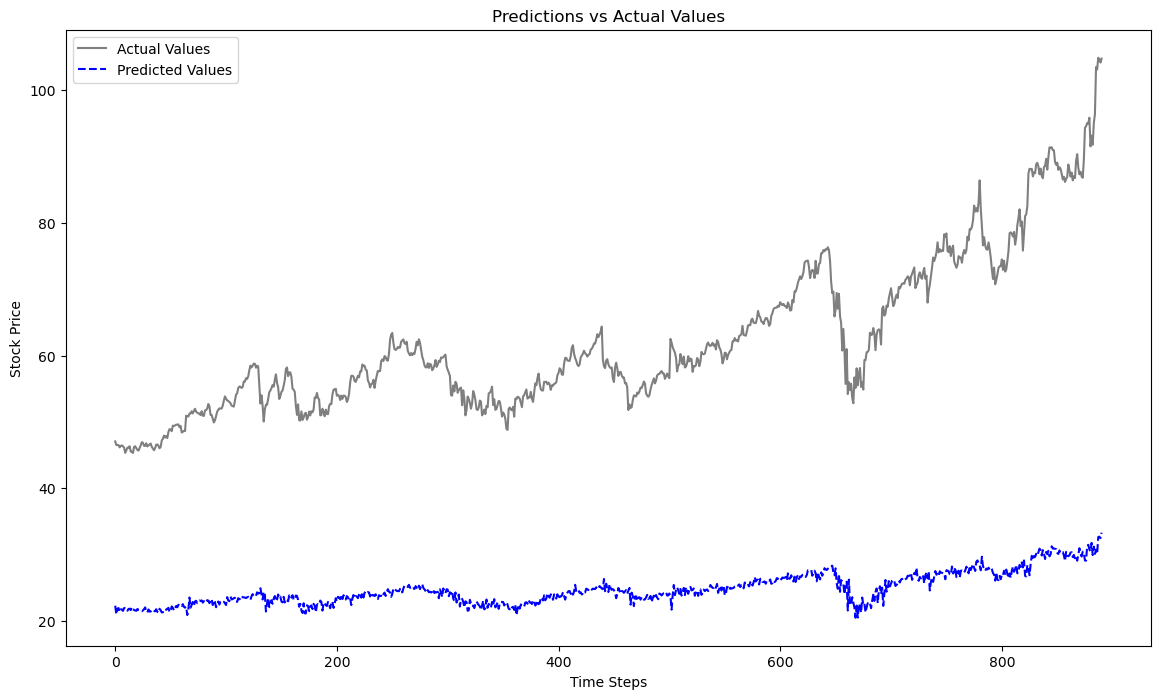

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with params: {'batch_size': 64, 'dropout': 0.5, 'epochs': 50, 'units': 30}
Epoch 1/50


/Users/chung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0645 - val_loss: 0.2001 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0212 - val_loss: 0.1708 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0175 - val_loss: 0.1617 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0152 - val_loss: 0.1495 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142 - val_loss: 0.1420 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0133 - val_loss: 0.1346 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - val_loss: 0.1231 - learning_rate: 0.0010
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - val_loss: 0.1188 - learning_rate: 0.0010
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - val_loss: 0.1134 - learning_rate: 0.0010
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━

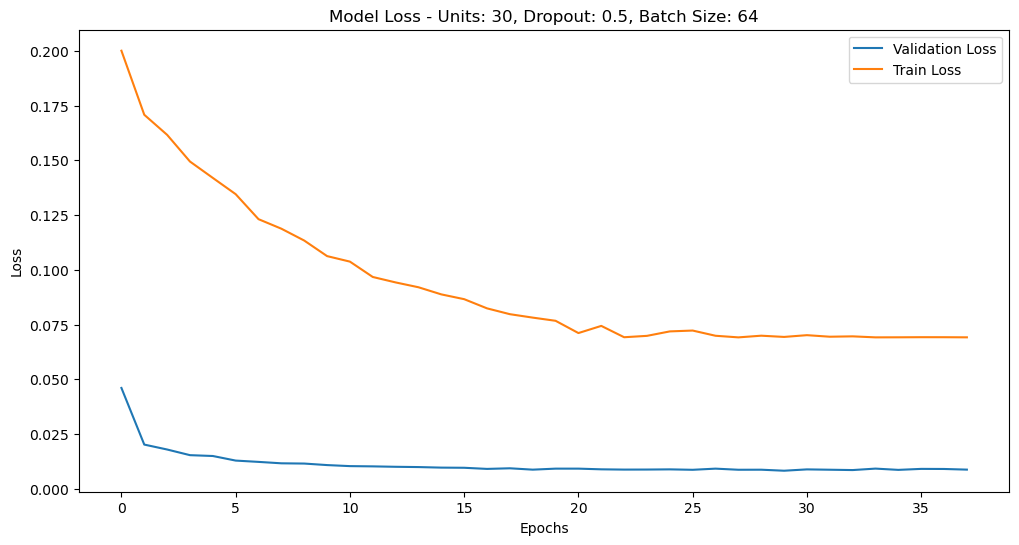

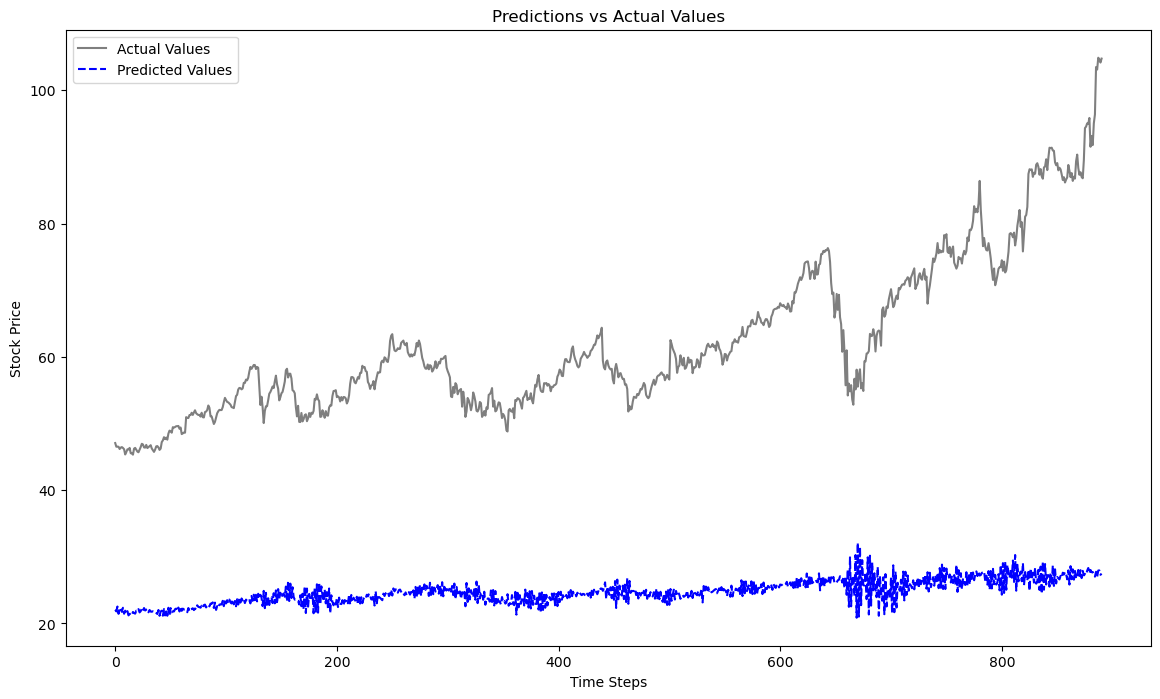

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Best parameters: {'batch_size': 64, 'dropout': 0.3, 'epochs': 50, 'units': 30}, Best MSE: 59.39351625720407


In [29]:
param_grid = {
    'units': [10, 30],
    'dropout': [0.3, 0.5],
    'batch_size': [64],
    'epochs': [50]
}

best_mse = float('inf')
best_model = None
best_params = {}

for params in ParameterGrid(param_grid):
    print(f"Training with params: {params}")
    model = build_baseline_rnn_model((X_train.shape[1], X_train.shape[2]))
    model.add(Dropout(params['dropout']))
    
    model = train_and_save_model(model, f"rnn_{params['units']}_{params['dropout']}_{params['batch_size']}",
                                 X_train, y_train, X_val, y_val, epochs=params['epochs'], batch_size=params['batch_size'], params=params)
    
    y_pred = model.predict(X_val)
    y_test_rescaled, y_pred_rescaled = inverse_transform_data(scaler, y_val, y_pred)   
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)

    if mse < best_mse:
        best_mse = mse
        best_model = model
        best_params = params

print(f"Best parameters: {best_params}, Best MSE: {best_mse}")

Training GRU with params: {'batch_size': 32, 'dropout': 0.5, 'epochs': 50, 'units': 5}
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0065 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0026 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0017 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.7361e-04 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.2809e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 9/50
100/10

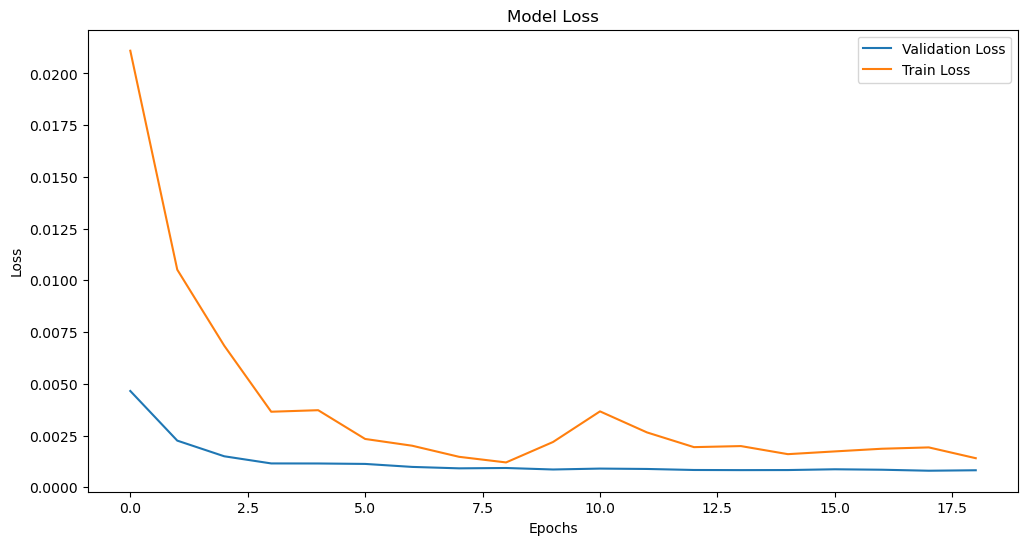

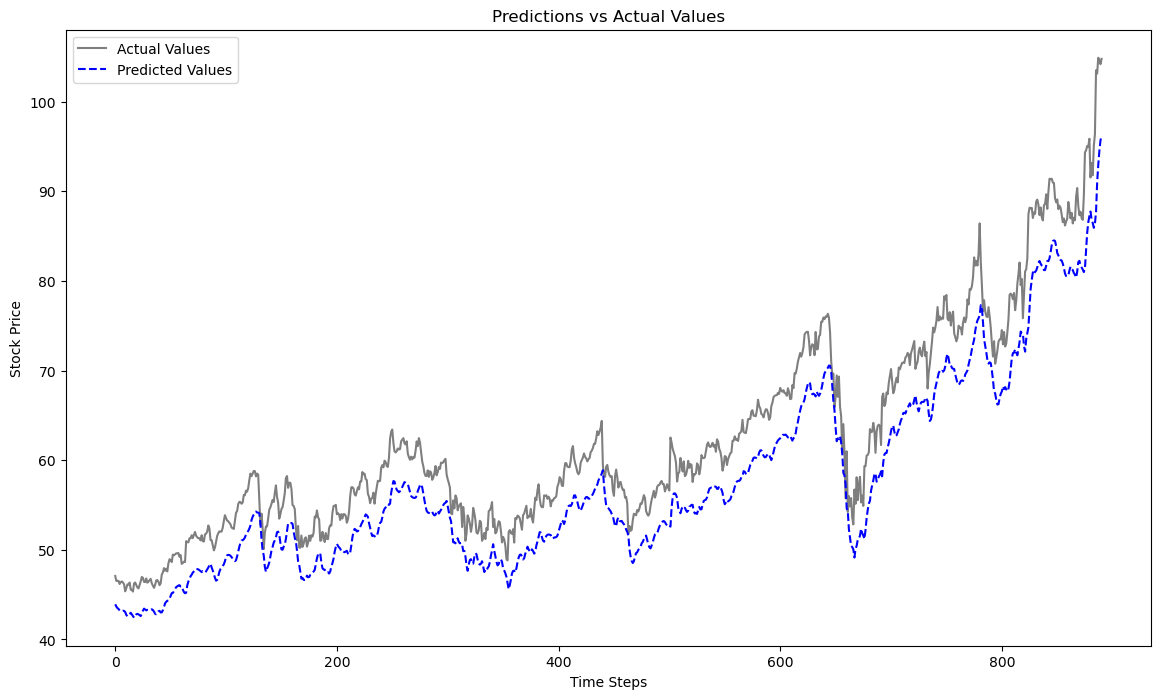

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training GRU with params: {'batch_size': 32, 'dropout': 0.5, 'epochs': 50, 'units': 10}
Epoch 1/50


/Users/chung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0059 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.2791e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4389e-04 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3783e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.1415e-04 - val_loss: 4.3226e-04 - learning_rate: 0.0010
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.6711e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6173e-04 - val_loss: 0.0013 - learni

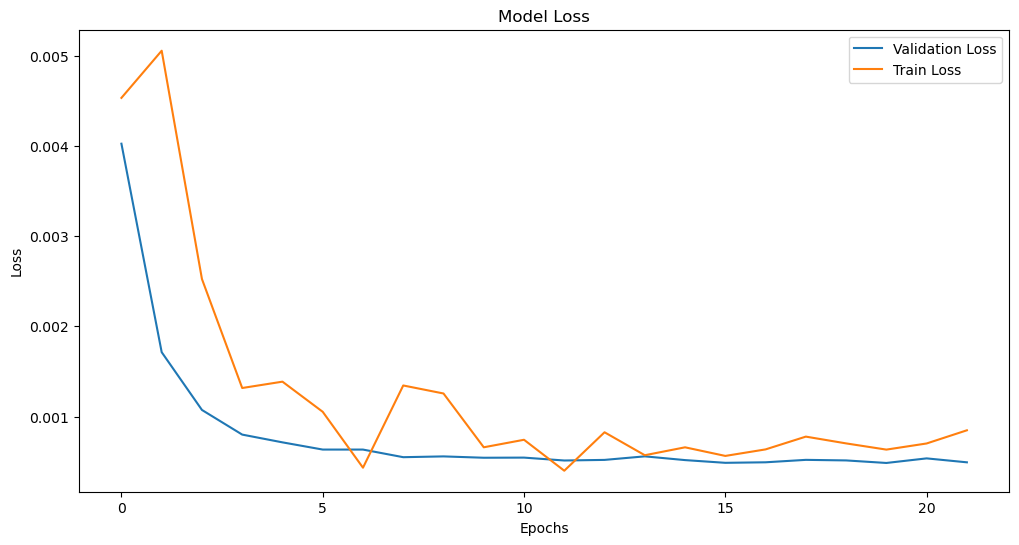

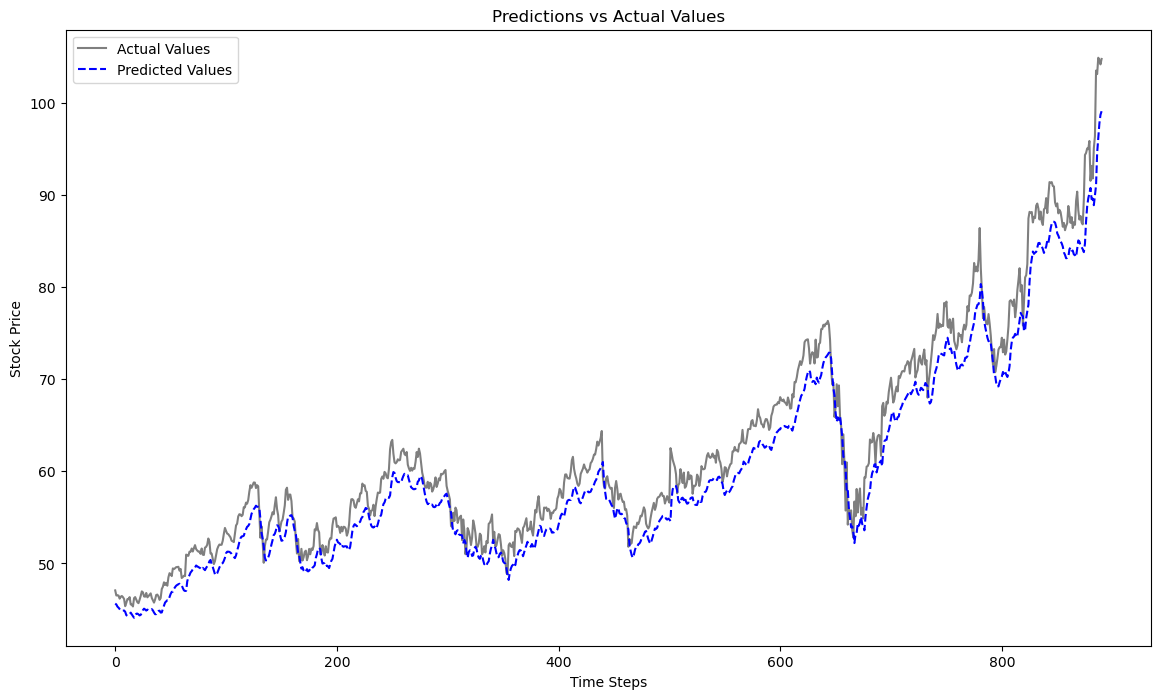

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training GRU with params: {'batch_size': 32, 'dropout': 0.7, 'epochs': 50, 'units': 5}
Epoch 1/50


/Users/chung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0516 - val_loss: 0.1351 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0151 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0087 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0064 - val_loss: 0.0249 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0044 - val_loss: 0.0176 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037 - val_loss: 0.0146 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025 - val_loss: 0.0129 - learning_rate: 0.0010
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 10/50


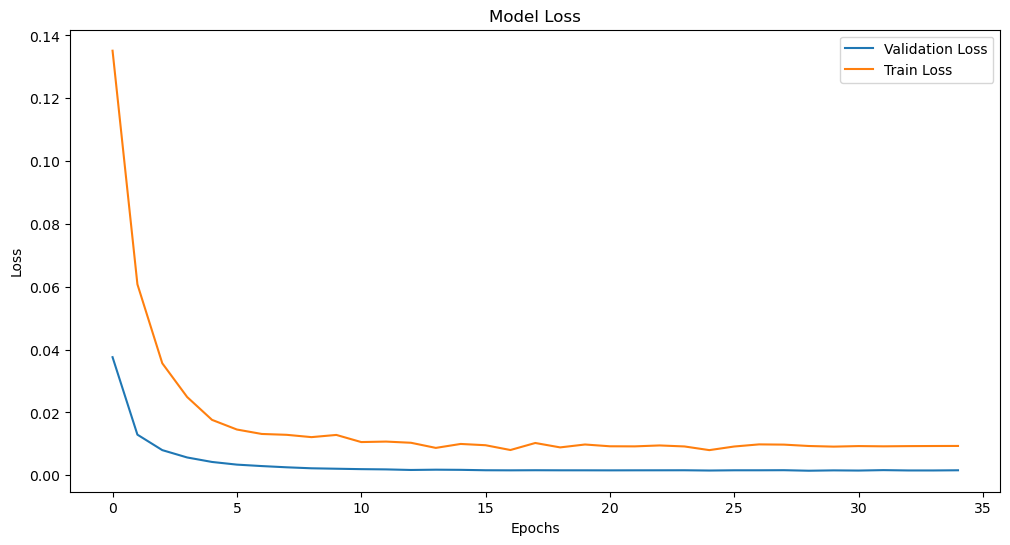

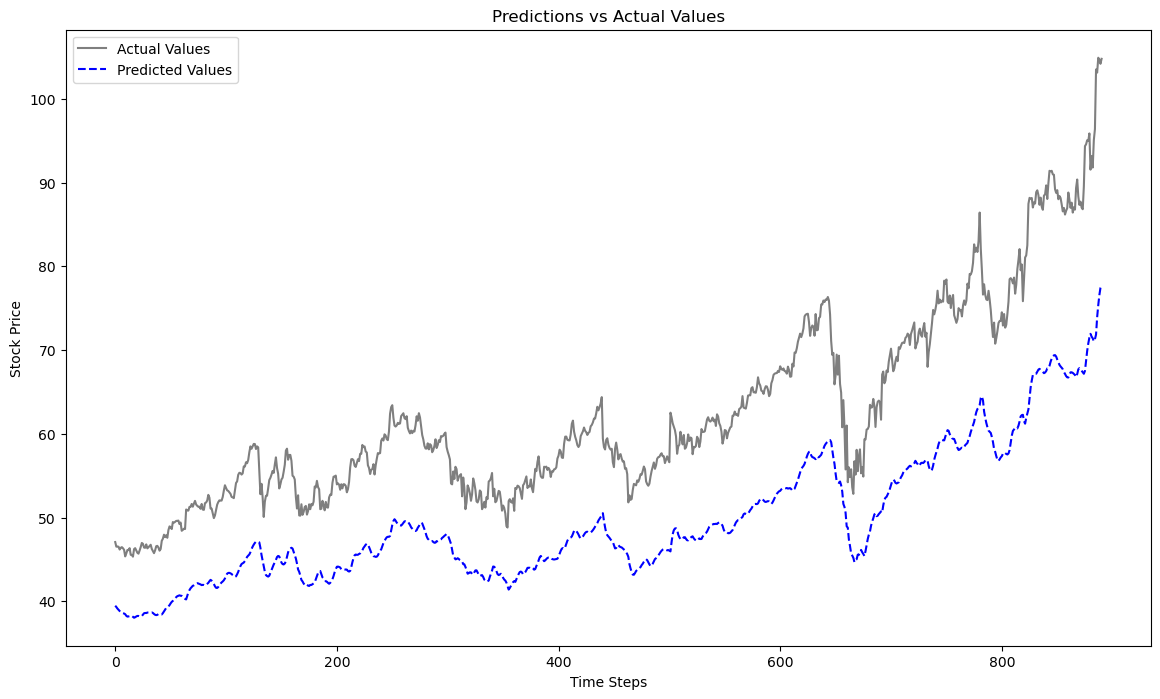

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training GRU with params: {'batch_size': 32, 'dropout': 0.7, 'epochs': 50, 'units': 10}
Epoch 1/50


/Users/chung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0223 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0042 - learning_ra

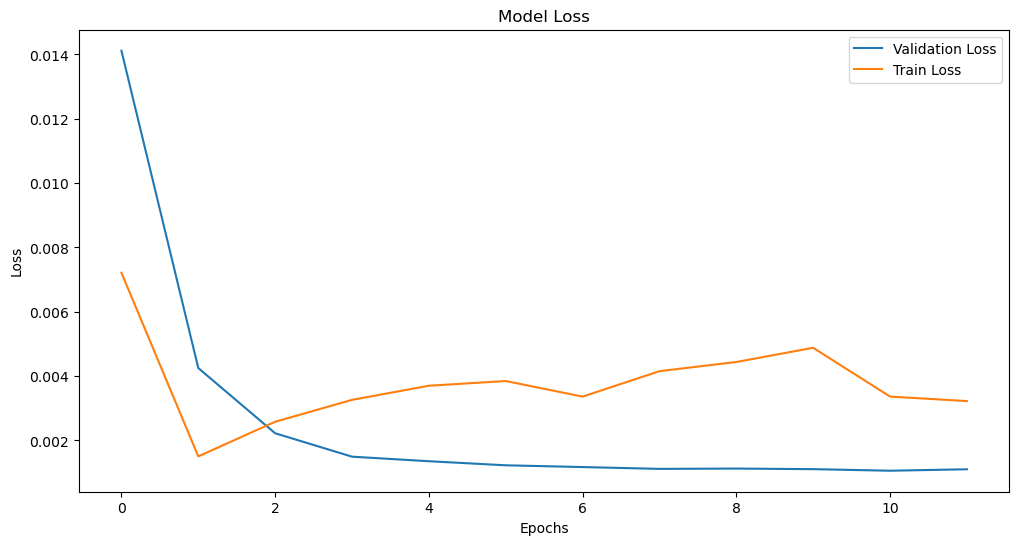

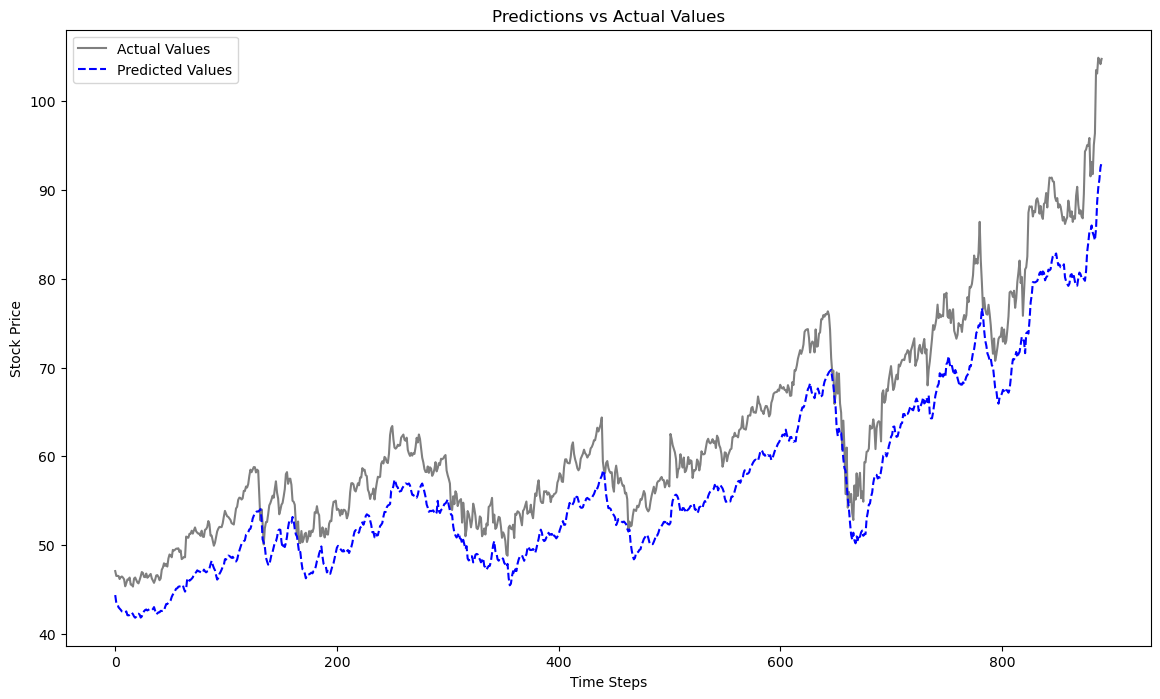

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best GRU parameters: {'batch_size': 32, 'dropout': 0.5, 'epochs': 50, 'units': 10}, Best MSE: 8.760115789558785


In [35]:
def build_gru_model(input_shape, units=10, dropout=0.5):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

param_grid_gru = {
    'units': [5, 10],
    'dropout': [0.5, 0.7],
    'batch_size': [32],
    'epochs': [50]
}

best_mse_gru = float('inf')
best_model_gru = None
best_params_gru = {}

for params in ParameterGrid(param_grid_gru):
    print(f"Training GRU with params: {params}")
    
    model = build_gru_model((X_train.shape[1], X_train.shape[2]), units=params['units'], dropout=params['dropout'])
    
    model = train_and_save_model(model, f"gru_{params['units']}_{params['dropout']}_{params['batch_size']}", 
                                 X_train, y_train, X_val, y_val, epochs=params['epochs'], batch_size=params['batch_size'])
    
    y_pred = model.predict(X_val)
    y_test_rescaled, y_pred_rescaled = inverse_transform_data(scaler, y_val, y_pred)   
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    if mse < best_mse_gru:
        best_mse_gru = mse
        best_model_gru = model
        best_params_gru = params

print(f"Best GRU parameters: {best_params_gru}, Best MSE: {best_mse_gru}")


Training LSTM with params: {'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'units': 5}


/Users/chung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0037 - val_loss: 8.1979e-04 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.5522e-04 - val_loss: 3.6524e-04 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.6287e-04 - val_loss: 2.5379e-04 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.0504e-04 - val_loss: 2.1578e-04 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.3979e-04 - val_loss: 2.2641e-04 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8361e-04 - val_loss: 3.0272e-04 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7707e-04 - val_loss: 1.8964e-04 - learning_rate: 0.0010
Epoch 8/50
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6837e-04
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
100/100 ━━━━━━━━━━━━━━

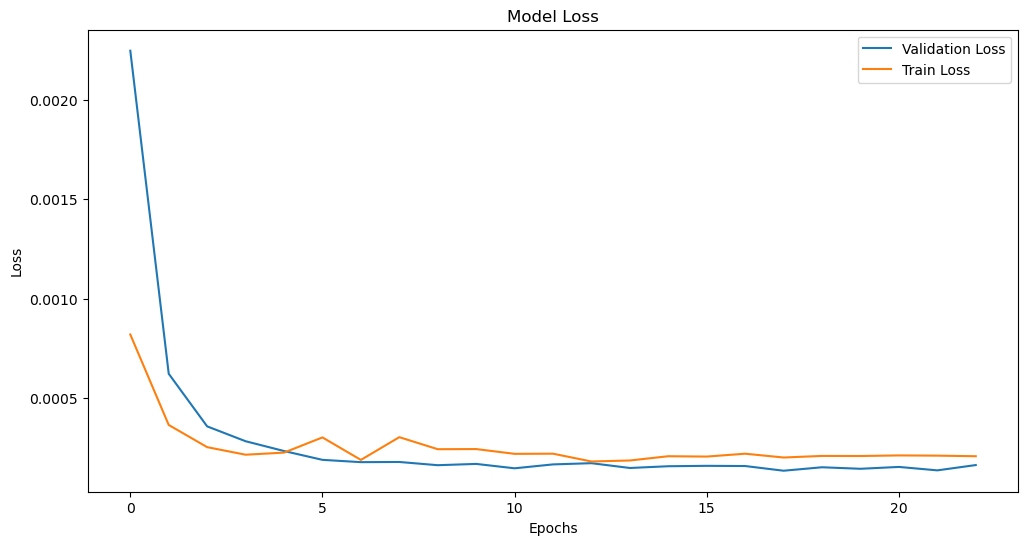

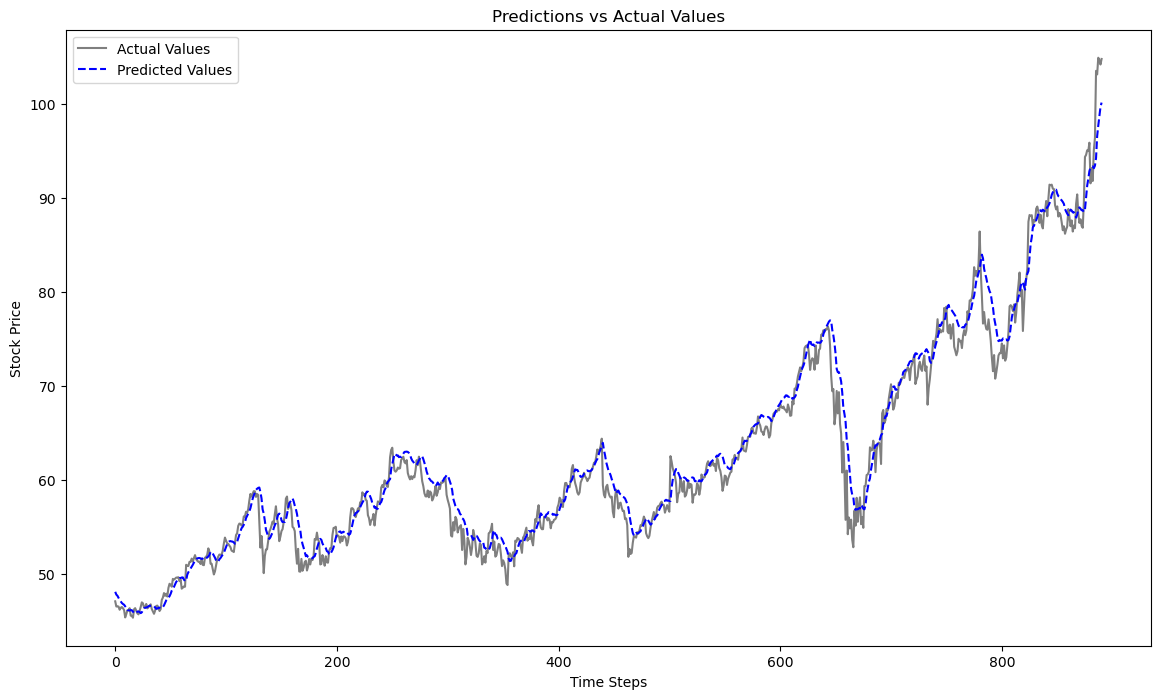

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Training LSTM with params: {'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'units': 50}
Epoch 1/50


/Users/chung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0014 - val_loss: 2.4342e-04 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.6053e-04 - val_loss: 1.6339e-04 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.0993e-04 - val_loss: 1.8148e-04 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.3293e-05 - val_loss: 1.8113e-04 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 7.3618e-05 - val_loss: 2.2969e-04 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4196e-05
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.4179e-05 - val_loss: 1.4730e-04 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.9987e-05 - val_loss: 1.4627e-04 - learning_rate: 2.0000e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 

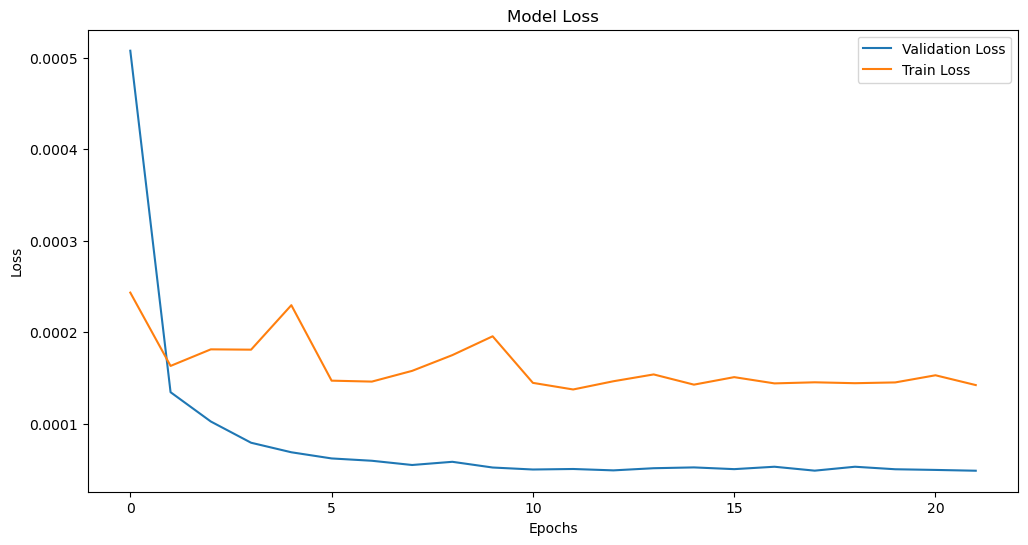

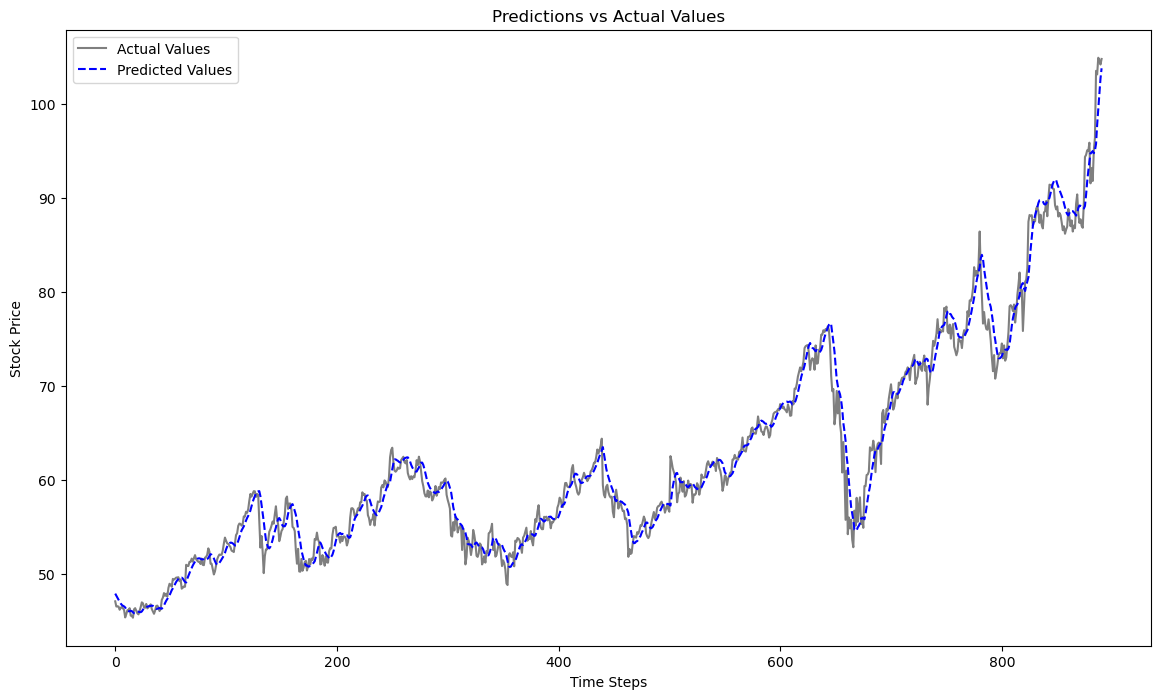

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Training LSTM with params: {'batch_size': 32, 'dropout': 0.7, 'epochs': 50, 'units': 5}
Loading pre-trained model: lstm_5_0.7_32


/Users/chung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Loaded history for model lstm_5_0.7_32
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Mean Squared Error: 41.1049946734545
Mean Absolute Error: 6.0298929238610715


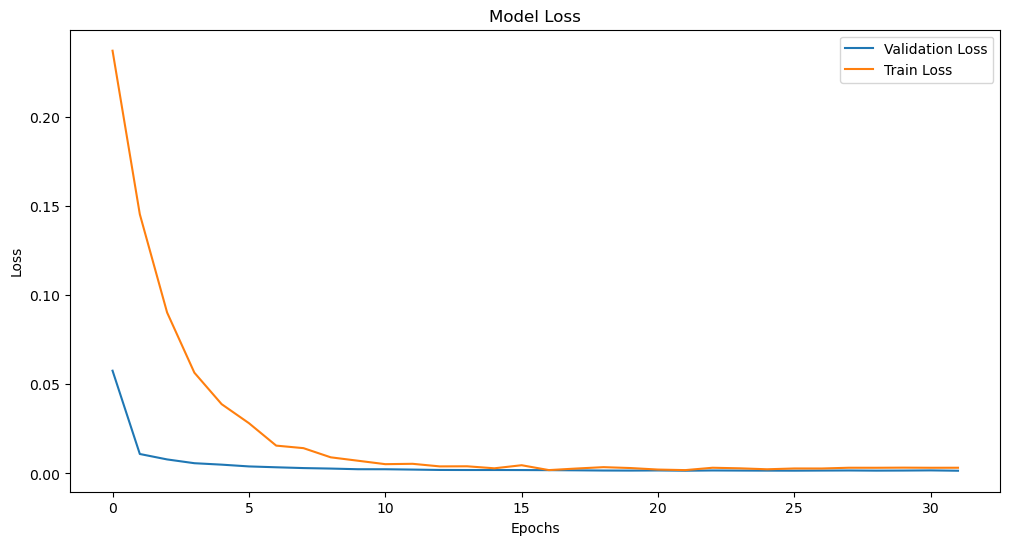

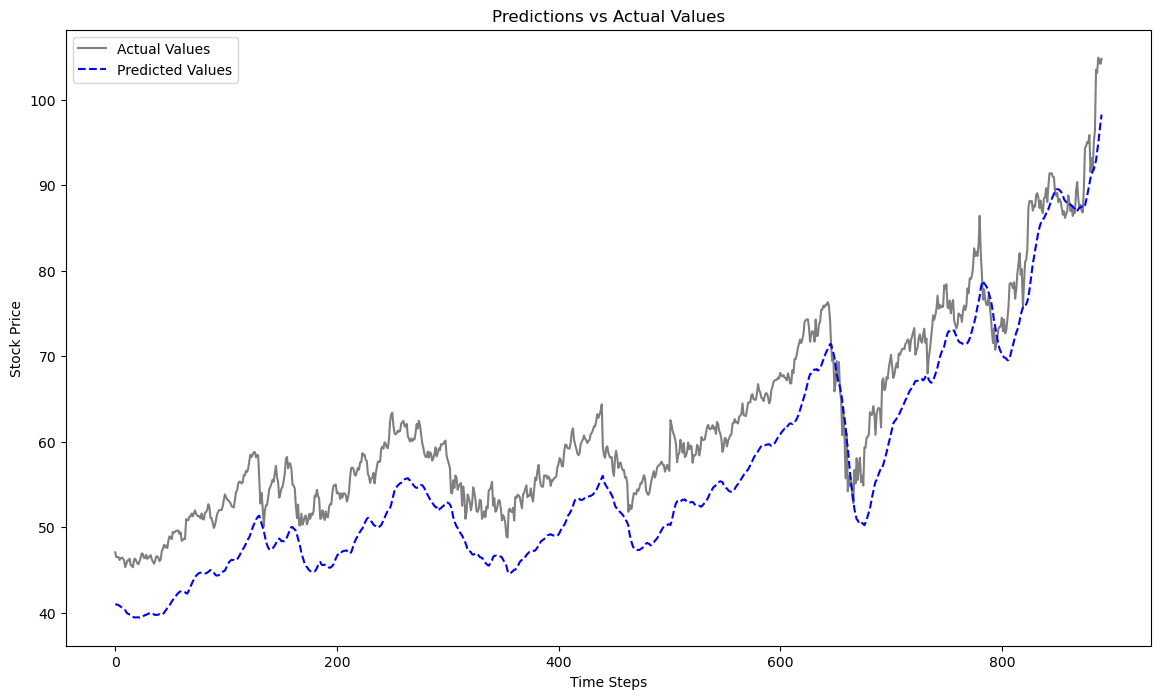

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Training LSTM with params: {'batch_size': 32, 'dropout': 0.7, 'epochs': 50, 'units': 50}
Epoch 1/50


/Users/chung/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0041 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 8.1617e-04 - val_loss: 6.0684e-04 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.2616e-04 - val_loss: 2.6906e-04 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.0956e-04 - val_loss: 4.5996e-04 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.4706e-04 - val_loss: 8.4212e-04 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.3014e-04 - val_loss: 3.1897e-04 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.0450e-04 - val_loss: 3.6477e-04 - learning_rate: 0.0010
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.7387e-04
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/

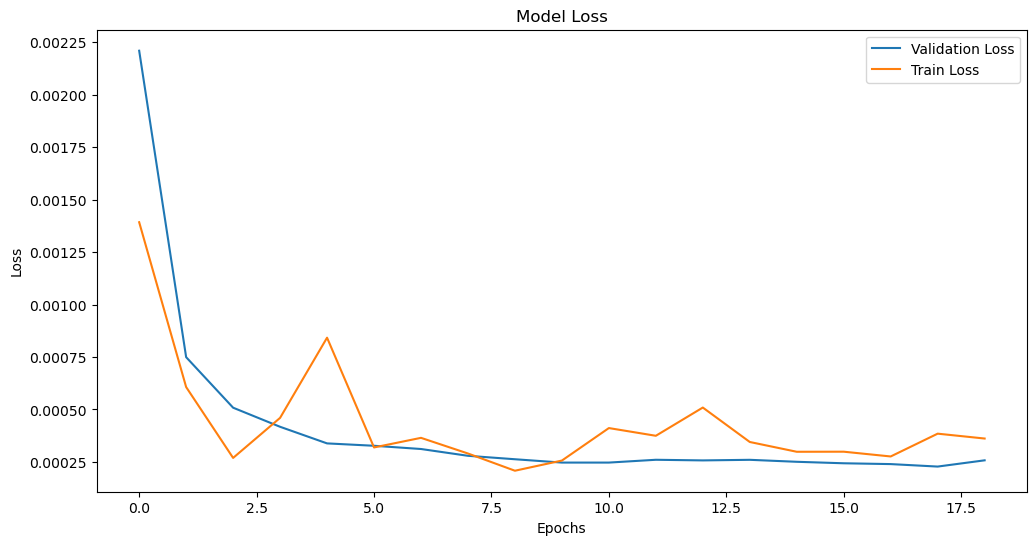

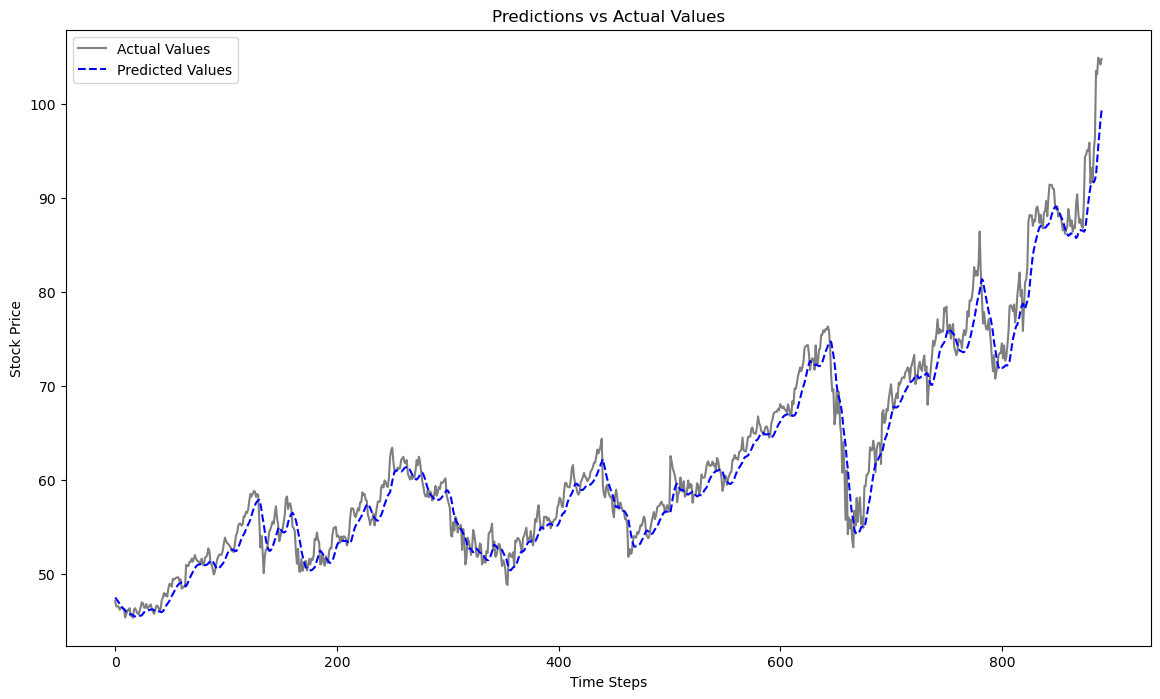

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Best LSTM parameters: {'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'units': 50}, Best MSE: 3.0245054028802376


In [42]:
def build_lstm_model(input_shape, units=10, dropout=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

param_grid_lstm = {
    'units': [5, 10],
    'dropout': [0.5, 0.7],
    'batch_size': [32],
    'epochs': [50]
}

best_mse_lstm = float('inf')
best_model_lstm = None
best_params_lstm = {}

for params in ParameterGrid(param_grid_lstm):
    print(f"Training LSTM with params: {params}")
    
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), units=params['units'], dropout=params['dropout'])
    
    model = train_and_save_model(model, f"lstm_{params['units']}_{params['dropout']}_{params['batch_size']}", 
                                 X_train, y_train, X_val, y_val, epochs=params['epochs'], batch_size=params['batch_size'])
    
    y_pred = model.predict(X_val)
    y_test_rescaled, y_pred_rescaled = inverse_transform_data(scaler, y_val, y_pred)   
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    if mse < best_mse_lstm:
        best_mse_lstm = mse
        best_model_lstm = model
        best_params_lstm = params

print(f"Best LSTM parameters: {best_params_lstm}, Best MSE: {best_mse_lstm}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Test MSE: 40.6025, Test MAE: 0.0384


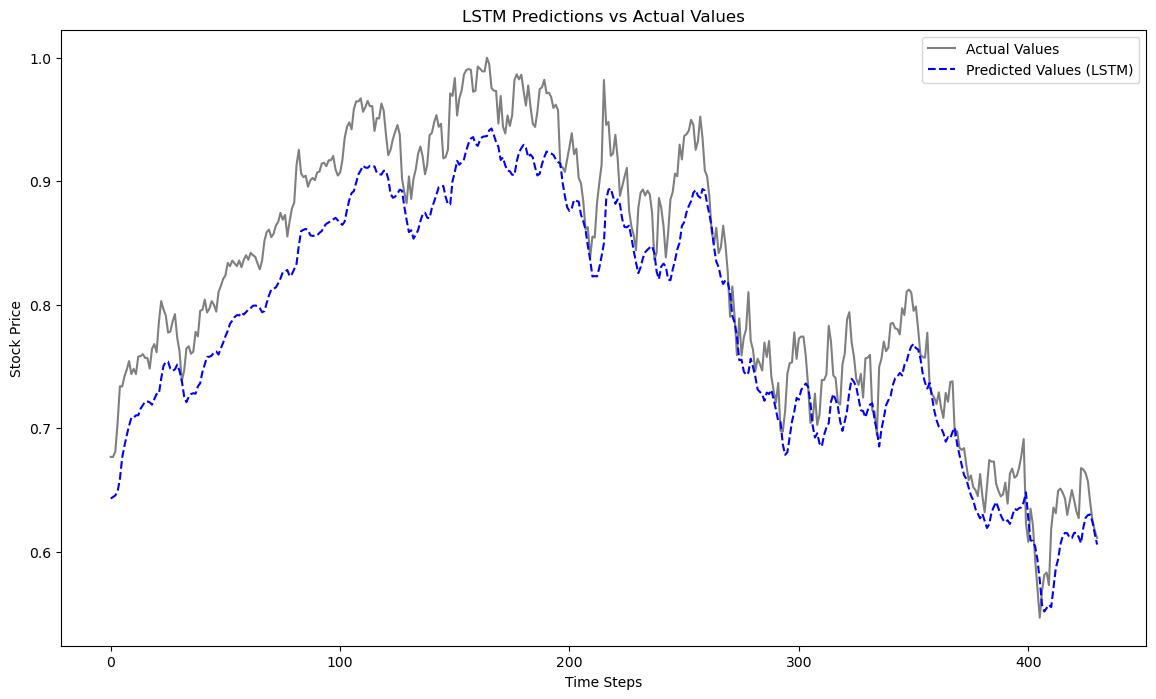

In [46]:
best_model_filename = 'save/gru_10_0.5_32.keras'
best_model = load_model(best_model_filename)

y_pred = best_model.predict(X_test)

y_test_rescaled, y_pred_rescaled = inverse_transform_data(scaler, y_test, y_pred)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}, Test MAE: {mae:.4f}")

plt.figure(figsize=(14, 8))
plt.plot(y_test, label='Actual Values', linestyle='-', color='black', alpha=0.5)
plt.plot(y_pred, label='Predicted Values (LSTM)', linestyle='--', color='blue')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
